### LSST AGN SC Regression Example

Gordon Richards and Weixiang Yu, Drexel University, February 2020

This notebook contains example code for learning how to use the AGN training set in the SciServer environment.  See https://github.com/RichardsGroup/LSST_training.

It specifically contains example code illustrating Pandas, Matplotlib, and SciKit-Learn tools that can be used to develop intitial photo-z algorithms for AGN in the LSST context.

Where possible and appropriate, we make reference to [Jake Vanderplas' Handbook for Data Science Python]( https://jakevdp.github.io/PythonDataScienceHandbook/).

In [1]:
#Load the various packages that we'll need
import numpy as np 
import pandas as pd #to enable the use of fancy data tables
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn #SciKit-Learn machine learning package for python
import zarr #See Setup.ipynb
pd.set_option('display.max_columns', 999)
from utils import * #See Setup.ipynb

#So that plots will be displayed inline
%matplotlib inline 

In [2]:
#See what versions of the software we are running
from platform import python_version
print(python_version())
print(np.version.version)
print(pd.__version__)
print(mpl.__version__)
print(sklearn.__version__)

3.7.6
1.18.4
0.24.2
3.1.3
0.23.0


In [3]:
## If using SciServer
# See Get_started.ipynb
init()

Start by loading up the quasar database into a [Pandas DataFrames](https://jakevdp.github.io/PythonDataScienceHandbook/03.00-introduction-to-pandas.html).

In [4]:
qso_df = get_qso_cat()
qso_df.head(5)

,train_id,ra,dec,z,z_err,thing_id,specobjid,spec,sdss_objid,psfmagerr_u,psfmagerr_g,psfmagerr_r,psfmagerr_i,psfmagerr_z,extinction_u,extinction_g,extinction_r,extinction_i,extinction_z,type,run,src2photo,dered_u,dered_g,dered_r,dered_i,dered_z,ra_sp,dec_sp,spies_id,flux_auto_ch1,fluxerr_auto_ch1,flux_auto_ch2,fluxerr_auto_ch2,class_star_ch1,class_star_ch2,src2spies,src2gaia,gaia_id,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,galex_id,fuv_mag,fuv_magerr,nuv_mag,nuv_magerr,src2galex,mpstype,stdColor[0],stdColor[1],stdColor[2],stdColor[3],psFlux[u],psFlux[g],psFlux[r],psFlux[i],psFlux[z],psPm[0],psPm[1],psParallax,lcN,class
0,0,310.0377,-1.005592,2.167268,0.000676,NaN,276352159556042752,7,8647475119809364088,0.008446,0.003265,0.003569,0.002969,0.005960,0.332155,0.244397,0.177257,0.134408,0.095297,6,206,0.083856,19.312095,18.875304,18.513243,18.263452,18.025003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.024083,4226318531605912576,0.225240,0.283972,-0.609215,0.464463,-0.206735,0.305267,6401869206833334272,NaN,NaN,23.184412,0.436260,1.696868,0.0,0.436792,0.362060,0.249792,0.238449,65942.328054,68419.255122,142798.907734,179737.984132,228014.565848,-0.609215,-0.206735,0.225240,55,qso
1,3,311.6088,0.393812,0.333015,0.000351,NaN,537282917827608576,7,8647475121420632840,0.011383,0.001996,0.001869,0.002298,0.003088,0.494767,0.364045,0.264036,0.200210,0.141952,3,206,0.051798,19.489293,18.512125,17.722814,17.683700,16.975958,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.092993,4228017414511443968,-0.149525,0.160723,0.044235,0.275073,0.075344,0.179892,2468467513536552960,21.218325,0.061310,21.052940,0.047003,0.742009,0.0,0.977168,0.789311,0.039115,0.707741,56011.332155,58115.957521,295732.889174,306580.434350,599285.639829,0.044235,0.075344,-0.149525,63,qso
2,4,312.3636,0.718380,1.699121,0.000973,NaN,314071864353751040,7,8647475121957832451,0.037532,0.009041,0.007869,0.007637,0.022191,0.526905,0.387692,0.281186,0.213215,0.151172,3,206,0.154056,21.131835,20.595028,20.152444,19.718245,19.668558,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.218568,4228378535360380928,-0.486411,0.729782,-0.776679,2.051325,0.635052,1.033818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.536807,0.442585,0.434199,0.049687,12319.895839,12794.084912,31547.575429,47059.204593,50039.124902,-0.776679,0.635052,-0.486411,47,qso
3,5,312.4020,0.834625,0.475306,0.000354,NaN,314071864311808000,7,8647475121957831705,0.020328,0.005620,0.006083,0.007393,0.019640,0.520510,0.382986,0.277773,0.210627,0.149337,3,206,0.160105,20.403761,20.042354,19.884427,19.652183,19.501243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2468502697908636672,22.338091,0.160893,21.475634,0.056155,0.364936,0.0,0.361406,0.157927,0.232244,0.150940,24118.091101,25029.261444,40383.598908,50012.543099,58422.366330,NaN,NaN,NaN,108,qso
4,6,312.4340,0.455123,2.080289,0.001066,NaN,314353417491316736,7,8647474692461166737,0.013942,0.005312,0.006064,0.007587,0.019144,0.459490,0.338089,0.245210,0.185935,0.131831,6,106,0.150507,19.954390,20.005581,19.965770,19.760675,19.543730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.100156,4228358022596119040,0.250211,0.772921,1.965712,2.234255,-0.107082,1.024258,2468537882278632960,NaN,NaN,23.030893,0.171892,0.508715,0.0,-0.051192,0.039811,0.205095,0.216945,36491.532269,37865.005535,37467.915153,45254.921252,56170.337863,1.965712,-0.107082,0.250211,50,qso


What columns are available to us?

In [5]:
qso_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24570 entries, 0 to 24569
Data columns (total 66 columns):
train_id            24570 non-null Int64
ra                  24570 non-null float64
dec                 24570 non-null float64
z                   24570 non-null float64
z_err               24570 non-null float64
thing_id            17481 non-null Int64
specobjid           24570 non-null Int64
spec                24570 non-null int64
sdss_objid          24570 non-null Int64
psfmagerr_u         24570 non-null float64
psfmagerr_g         24570 non-null float64
psfmagerr_r         24570 non-null float64
psfmagerr_i         24570 non-null float64
psfmagerr_z         24570 non-null float64
extinction_u        24570 non-null float64
extinction_g        24570 non-null float64
extinction_r        24570 non-null float64
extinction_i        24570 non-null float64
extinction_z        24570 non-null float64
type                24570 non-null int64
run                 24570 non-null int64
sr

For now, let's just use the colors as indicated in the following cell.

In [6]:
collist = ['ra','dec','stdColor[0]','stdColor[1]','stdColor[2]','stdColor[3]','z']
train_df = qso_df[collist]

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24570 entries, 0 to 24569
Data columns (total 7 columns):
ra             24570 non-null float64
dec            24570 non-null float64
stdColor[0]    24570 non-null float64
stdColor[1]    24570 non-null float64
stdColor[2]    24570 non-null float64
stdColor[3]    24570 non-null float64
z              24570 non-null float64
dtypes: float64(7)
memory usage: 1.3 MB


SciKit-Learn uses a convention where "X" is a multi-dimensional matrix of features (columns) for each object (rows).  In the case of regression "y" are the "answers", which here means the redshift.

We'll next build both "y" and "X" (the order is important) from our training dataframe.  

"y" is just the values of redshift.

Once the label array, y, is defined, we drop that information from the dataframe (otherwise, we'd be cheating!) and define "X".  Let's also drop RA and Dec.

In [8]:
y = train_df['z'].values
y

array([2.167268, 0.333015, 1.699121, ..., 2.609345, 2.097516, 0.2843  ])

In [10]:
X = train_df.drop(['ra','dec','z'],axis=1).values
X
print(X.shape)

(24570, 4)


Let's take a look at the data.

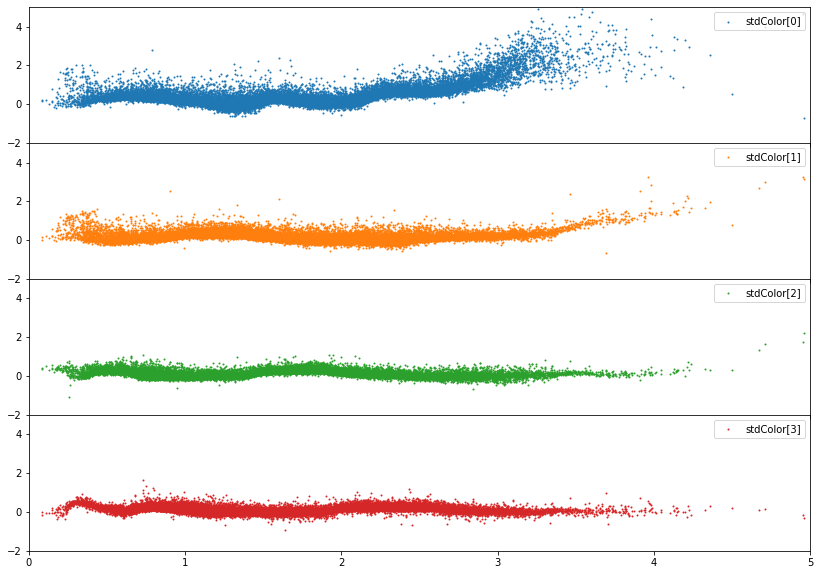

In [11]:
fig, axarr = plt.subplots(4, sharex='col',gridspec_kw={'hspace':0, 'wspace':0},figsize=(14,10))
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

for i,ax in enumerate(axarr):
    ax.scatter(y,X[:,i], s=1, color=cycle[i], label=train_df.columns[i+2])
    ax.legend(loc='upper right')
    ax.set_ylim([-2,5])
    ax.set_xlim([0,5])

We are going to try to use the fact that the "shape" of this distribution with redshift is different for each color to predict the redshift of new objects that lack spectroscopy.

In the classification example, the Random Forest worked pretty well, so let's try the [Random Forest Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html).

In [12]:
from sklearn.ensemble import RandomForestRegressor

In [13]:
model = RandomForestRegressor(n_estimators=100,random_state=42)

In [14]:
from sklearn.model_selection import cross_val_predict
y_pred = cross_val_predict(model, X, y, cv=5)

Let's plot the known redshift vs. the predicted redshift to see how we did.

Text(0, 0.5, 'Photo-z')

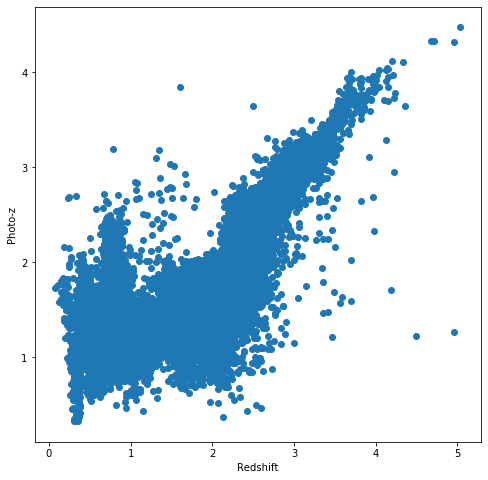

In [15]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(y,y_pred)
ax.set_xlabel('Redshift')
ax.set_ylabel('Photo-z')

This looks terrible!  But it really is not as bad as it seems (as we can see by making a better plot).

In [16]:
#Put the known redshift and predicted redshift into a new Pandas dataframe.
df = pd.DataFrame({'Redshift':y,'Photo-z':y_pred})

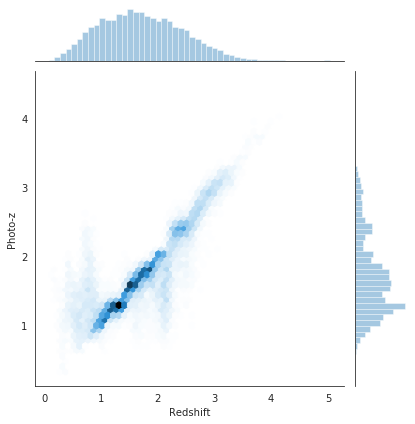

In [18]:
#Make a fancy plot
import seaborn as sea
with sea.axes_style('white'):
    sea.jointplot('Redshift','Photo-z',df, kind='hex')

While we can certainly do a lot better, most of the objects have their redshifts well predicted, which is also illustrated by the following histogram.

Text(0.5, 0, 'z_{spec} - z_{phot}')

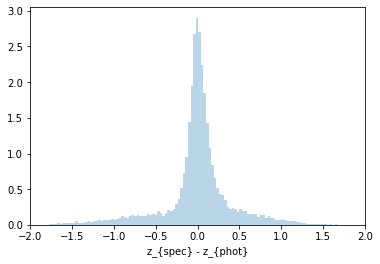

In [19]:
#Plot a histogram of the results
kwargs = dict(histtype='stepfilled', alpha=0.3, density=True, bins=200)
plt.hist(y-y_pred, **kwargs);
plt.xlim(-2,2)
plt.xlabel('z_{spec} - z_{phot}')

We might like to know which features contributed the most to the accuracy.  This will be especially true when we start including novel features like DCR.

In this case that information is stored in the `feature_importances_`.

In [20]:
model.fit(X,y)
model.feature_importances_

array([0.51083735, 0.16621239, 0.21090232, 0.11204794])

We see that $u-g$ contributes the most (by far), followed by $r-i$, then $g-r$, and finally $i-z$.

Ultimately our algorithm (likely multiple algorithms) will need to produce full PDFs and ideally will handle both the LLAGN and luminous quasars.